# Investigating different sources of error

- This notebook investigates the different sources of error in age inference. Besides the "bimodality" that we discuss at length in the manuscript, we also looked at whether protein length, number of domains, and evolutionary rate correlated with node error, our main error statistic
- We also investigate whether protein length and evolutionary rate affect the age call, with shorter, more highly evolving proteins coming out younger than they should due to limited sensitivity in the inital search used to identify homologs

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from itertools import combinations
%matplotlib inline

In [56]:
## Suppress copious FutureWarnings from pandas

import warnings
warnings.filterwarnings('ignore')

### Read in the different files with error-source information

In [6]:
# Protein lengths are from Uniprot proteome. Number of domains was inferred with hmmer. Similarities here are derived 
# from pairwise alignments (needleman-wunsch) between one-to-one human and mouse orthologs, defined by PhylomeDB. 
# We look atHuman-Yeast pairs below, but chose to use Mouse here because there are more one-to-ones.

lengths = pd.read_csv("lengthMapping.csv",index_col=0,names=["protLength"]).sort_index()
numDomains = pd.read_csv("numDomains.csv",index_col=0).sort_index()
mouse_human = pd.read_csv("h-m_similarities.csv",index_col=0,names=["Hs-Mm_sim"]).sort_index()

In [7]:
nodeStats = pd.read_csv("../../nodeStats/nodeStats_HUMAN.csv",index_col=0).sort_index()[["Bimodality","NodeError"]]

In [8]:
lossTaxa = pd.read_csv("../../Errors/lossStats_HUMAN.csv",index_col=0).sort_index()[["mean"]]
lossTaxa.columns = ["meanLossTaxa"]

In [9]:
fracOverSplit = pd.read_csv("../../Errors/HUMAN_LDO_summary.csv",index_col=0).sort_index()
fracOverSplit.columns = ["fracOverSplit"]

### Make concatenated dataframe

In [55]:
all_stats = pd.concat([lengths,numDomains,mouse_human,nodeStats,lossTaxa,fracOverSplit],axis=1)
all_stats.dropna(inplace=True)
all_stats = all_stats.convert_objects(convert_numeric=True)
all_stats.columns = ["Protein Length","# Domains","Hs-Mm_evoSim","Bimodality",
                     "Node Error","Avg. Loss Taxa","% Oversplit"]
all_stats.head()

,Protein Length,# Domains,Hs-Mm_evoSim,Bimodality,Node Error,Avg. Loss Taxa,% Oversplit
A0AV02,714.0,2.0,86.7,1.428571,2.769231,13.307692,0.555556
A0AV96,593.0,4.0,96.3,7.000000,4.769231,10.153846,1.000000
A0AVI4,362.0,1.0,94.2,0.007937,0.282051,2.461538,0.000000
A0AVK6,867.0,2.0,88.3,2.861111,4.512821,13.769231,0.500000
A0AVT1,1052.0,4.0,94.5,0.337302,2.487179,19.923077,1.000000


### Scatterplot and correlation analysis

> Only bimodality correlates strongly with the node error statistic

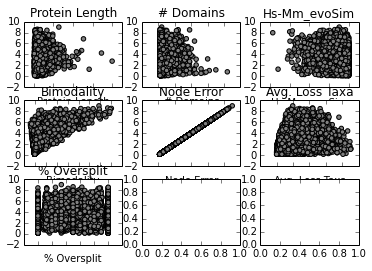

In [26]:
fig, axes = plt.subplots(3,3,sharey=False)
index = 0
for col in all_stats.columns:
    axis = axes.flat[index]
    all_stats.plot(ax=axis,kind='scatter',x=col,y='Node Error',color='grey',title=col)
    axis.set_ylabel('')
    axis.set_xticklabels([])
    index += 1
    
#fig.savefig("errorScatterPlot.png",dpi=200)

In [27]:
# Get Spearman rank correlations between all variables

correlations = all_stats.corr("spearman")
correlations

,Protein Length,# Domains,Hs-Mm_evoSim,Bimodality,Node Error,Avg. Loss Taxa,% Oversplit
Protein Length,1.000000,0.327528,-0.061458,0.069116,0.098448,0.071032,0.074736
# Domains,0.327528,1.000000,0.099203,0.041373,0.107270,0.079636,0.223168
Hs-Mm_evoSim,-0.061458,0.099203,1.000000,-0.029975,-0.134729,0.078357,-0.039889
Bimodality,0.069116,0.041373,-0.029975,1.000000,0.685699,0.061470,0.063460
Node Error,0.098448,0.107270,-0.134729,0.685699,1.000000,0.342641,0.061165
Avg. Loss Taxa,0.071032,0.079636,0.078357,0.061470,0.342641,1.000000,0.002736
% Oversplit,0.074736,0.223168,-0.039889,0.063460,0.061165,0.002736,1.000000


#### Plot absolute Spearman rank correlations with Node Error

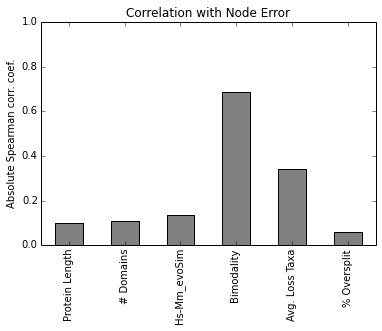

In [28]:
absCorrs = correlations.applymap(np.abs)

absCorrs.drop("Node Error",axis=1).ix["Node Error",].plot(
    kind='bar',color='grey',ylim=(0,1),title="Correlation with Node Error")
plt.ylabel("Absolute Spearman corr. coef.")

#plt.savefig("correlation_barPlot.svg")

In [29]:
# correlations.to_csv("errorCorrelations.csv")

### Human-yeast evolutionary rates and node errors

- Now we'll take a quick look at yeast-human similarities. We used mouse above because there are many one-to-one orthologs, but the tradeoff is a small dynamic range. Human-yeast similarities have a stronger correlation with node error than human-mouse.

In [43]:
yeast_human = pd.read_csv("h-y_similarities.csv",index_col=0,names=["Hs-Sc_sim"]).sort_index()

In [57]:
error_yeastSims = pd.concat([nodeStats,yeast_human],axis=1).dropna()[["Hs-Sc_sim","NodeError"]]
error_yeastSims = error_yeastSims.convert_objects(convert_numeric=True)
print "Number of alignments: %d" % len(error_yeastSims)

Number of alignments: 892


In [52]:
error_yeastSims.corr()

,Hs-Sc_sim,NodeError
Hs-Sc_sim,1.000000,-0.357516
NodeError,-0.357516,1.000000


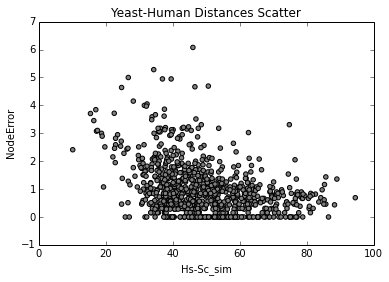

In [53]:
error_yeastSims.plot(kind='scatter',y="NodeError",x="Hs-Sc_sim",color='grey',title="Yeast-Human Distances Scatter")

#plt.savefig("Yeast-Human_dists_scatter.png",dpi=600)

### Effect of protein lengths and evolutionary distances on age-call.

- Does the limited sensitivity of homology search algorithms affect the age-call? Prediction of Moyers and Zhang (2015,2016) is that quickly evolving proteins and short proteins will be called at a younger age incorrectly.

- Takeaway from the below is that protein length and evolutionary rate may affect some of the proteins in the "Mammal" age class. So we cannot rule out that some of these are false negatives due to limited sensitivity in the initial homology search.

#### First we'll take a look at the distribution of human-mouse one-to-one alignment similarities. Most are highly similar.

array([[<matplotlib.axes.AxesSubplot object at 0x7fd552499650>]], dtype=object)

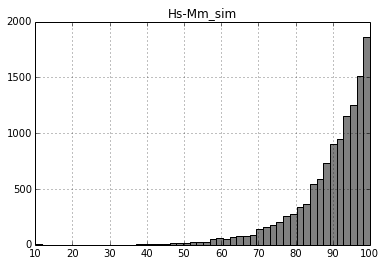

In [59]:
mouse_human.hist(bins=50,color='grey')

#### Distribution of protein lengths. Most are short

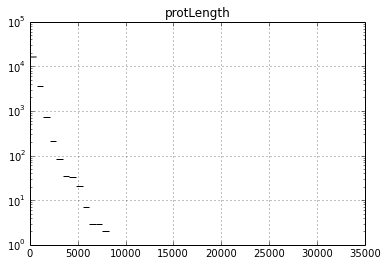

In [62]:
lengths.hist(bins=50,color='grey')
plt.yscale("log")

#### Add in the mode-ages

In [36]:
conAges = pd.read_csv("../../Main/main_HUMAN.csv",index_col=0)["modeAge"]
conAges.head()

A0A075B6G5    Eumetazoa
A0A075B6R3     Mammalia
A0A0A0MR89    Eumetazoa
A0A0A0MS98     Mammalia
A0A0A0MSJ3    Eukaryota
Name: modeAge, dtype: object

In [37]:
statsAges = all_stats.join(conAges).sort("modeAge")
statsAges.head()

,Protein Length,# Domains,Hs-Mm_evoSim,Bimodality,Node Error,Avg. Loss Taxa,% Oversplit,modeAge
A1Z1Q3,448,1,77.8,5.376984,7.256410,29.923077,0.8,Cellular_organisms
A2A3L6,582,16,43.2,0.452381,4.076923,20.307692,1.0,Cellular_organisms
A2RTX5,802,4,91.1,2.960317,4.871795,19.538462,0.4,Cellular_organisms
A2RU49,373,1,89.6,-0.305556,2.974359,13.692308,1.0,Cellular_organisms
A6NDG6,321,4,94.1,0.003968,1.974359,23.846154,0.0,Cellular_organisms


In [44]:
ages = ["Cellular_organisms","Euk+Bac","Euk_Archaea","Eukaryota",
        "Opisthokonta","Eumetazoa","Vertebrata","Mammalia"]

ageLengths = {}

for i in ages:
    df = statsAges[statsAges["modeAge"] == i]
    assert len(df) > 50 # just checkin'
    ageLengths[i] = df["Protein Length"].mean()

#### Average protein lengths in each age category. No strong correlation with age, but Mammals may be enriched for small proteins.

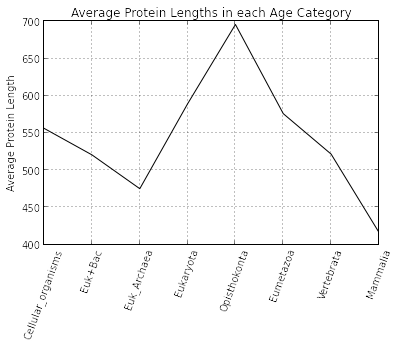

In [45]:
ax = pd.Series(ageLengths,index=ages).plot(color='black')
plt.xticks(rotation=70)
ax.set_ylabel("Average Protein Length")
ax.set_title("Average Protein Lengths in each Age Category")

#plt.savefig("lengthsXage.svg")

#### Average similarity in each age class. Mammals definitely enriched for more quickly evolving proteins. Some of these may be older than "Mammal" and are false-negatives.

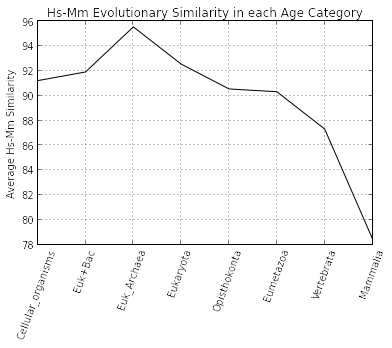

In [62]:
ageSims = {}

for i in ages:
    df = statsAges[statsAges["modeAge"] == i]
    assert len(df) > 50 # just checkin'
    ageSims[i] = df["Hs-Mm_evoSim"].mean()
    
ax = pd.Series(ageSims,index=ages).plot(color='black')
plt.xticks(rotation=70)
ax.set_ylabel("Average Hs-Mm Similarity")
ax.set_title("Hs-Mm Evolutionary Similarity in each Age Category")

#plt.savefig("Hs-Mm_similarityXage.svg")

#### Double-check that Mammal age class has significantly lower similarities in its proteins than Vertebrate class

In [56]:
# Create series for Mann-Whitney U-test

ageSimsSets = {}

for i in ages:
    df = statsAges[statsAges["modeAge"] == i]
    assert len(df) > 50 # just checkin'
    ageSimsSets[i] = df["Hs-Mm_evoSim"]

ageSimsSets["Mammalia"].head()

A1L4H1    70.1
A2RU30    71.3
A4D2G3    89.7
A6NCF6    61.6
A6NCV1    93.9
Name: Hs-Mm_evoSim, dtype: float64

In [103]:
## Mann-Whitney U-test

f,p = stats.mannwhitneyu(ageSimsSets["Vertebrata"],ageSimsSets["Mammalia"])
print "p-val Mammals and Vertebrate classes have same mean: %s" % p

p-val Mammals and Vertebrate classes have same mean: 1.68683397453e-30


In [104]:
ageCatSimsDF = pd.DataFrame(ageSimsSets,columns=ages)

#### Box plot of similarities

(array([1, 2, 3, 4, 5, 6, 7, 8]), <a list of 8 Text xticklabel objects>)

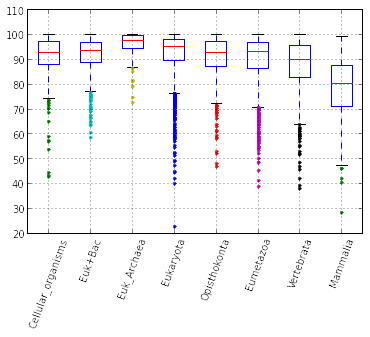

In [105]:
ax = ageCatSimsDF.boxplot(sym=".")
plt.ylim(20,110)
plt.xticks(rotation=70)